# percent-allocate

Maintain a percent allocation of a security in account

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 50
band = 3

sma200_band = 3.5/100

Define Strategy Class 

In [6]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        pf.TradeLog.cash = self._capital

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self._ts, i)
            shares = 0

            # adjust shares
            if ((self._tlog.percent(close) > target_percent+band or
                self._tlog.percent(close) < target_percent-band)
                and close > row.sma200*(1+sma200_band)
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent)   
            # close out
            elif (close < row.sma200*(1-sma200_band)
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)

        # Add technical indicator: 200 day sma
        sma200 = SMA(self._ts, timeperiod=200)
        self._ts['sma200'] = sma200
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._tlog = pf.TradeLog(self._symbol)
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,price,shares,entry_exit,direction,symbol
34,2015-08-21,179.10,80,exit,LONG,None
35,2016-04-01,190.40,77,entry,LONG,SPY
36,2017-02-13,217.67,5,exit,LONG,None
37,2017-11-28,249.32,5,exit,LONG,None
38,2018-10-29,254.83,67,exit,LONG,None
39,2019-03-18,275.46,62,entry,LONG,SPY
40,2019-12-12,312.36,4,exit,LONG,None
41,2020-03-09,271.43,58,exit,LONG,None
42,2020-06-03,310.81,54,entry,LONG,SPY
43,2020-06-22,310.62,54,exit,LONG,None


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
23,2012-01-10,108.94,2013-05-15,143.89,34.95,209.71,6,13133.94,LONG,SPY
24,2012-01-10,108.94,2014-02-28,163.89,54.95,329.71,6,13463.65,LONG,SPY
25,2012-01-10,108.94,2015-02-17,188.46,79.52,397.60,5,13861.24,LONG,SPY
26,2012-01-10,108.94,2015-08-21,179.10,70.16,5613.08,80,19474.32,LONG,SPY
27,2016-04-01,190.40,2017-02-13,217.67,27.26,136.32,5,19610.64,LONG,SPY
28,2016-04-01,190.40,2017-11-28,249.32,58.92,294.58,5,19905.22,LONG,SPY
29,2016-04-01,190.40,2018-10-29,254.83,64.42,4316.34,67,24221.56,LONG,SPY
30,2019-03-18,275.46,2019-12-12,312.36,36.89,147.58,4,24369.14,LONG,SPY
31,2019-03-18,275.46,2020-03-09,271.43,-4.03,-233.86,58,24135.28,LONG,SPY
32,2020-06-03,310.81,2020-06-22,310.62,-0.19,-10.38,54,24124.90,LONG,SPY


In [11]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-16,34321.30,33892.81,34321.30,54,17351.42,-
2020-06-17,34254.10,34064.31,34254.10,54,17351.42,-
2020-06-18,34141.73,33991.73,34141.73,54,17351.42,-
2020-06-19,34327.94,33904.04,34327.94,54,17351.42,-
2020-06-22,34124.90,34124.90,34124.90,0,34124.90,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2020-06-22
beginning_balance                                            10000
ending_balance                                            34124.90
total_net_profit                                          24124.90
gross_profit                                              24574.61
gross_loss                                                 -449.71
profit_factor                                                54.65
return_on_initial_capital                                   241.25
annual_return_rate                                            4.72
trading_period                           26 years 7 months 11 days
pct_time_in_market                                           75.13
total_num_trades                                                33
trades_per_year                                               1.24
num_winning_trades                                            

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2020-06-22 00:00:00 SELL 215 SPY @ 310.62


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                   1993-11-11
end                                                     2020-06-22
beginning_balance                                            10000
ending_balance                                            66812.67
total_net_profit                                          56812.67
gross_profit                                              56812.67
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                   568.13
annual_return_rate                                            7.40
trading_period                           26 years 7 months 11 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
trades_per_year                                               0.04
num_winning_trades                                            

Plot Equity Curves: Strategy vs Benchmark

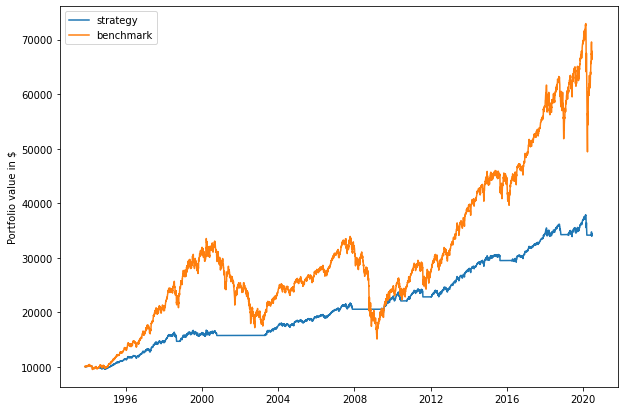

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

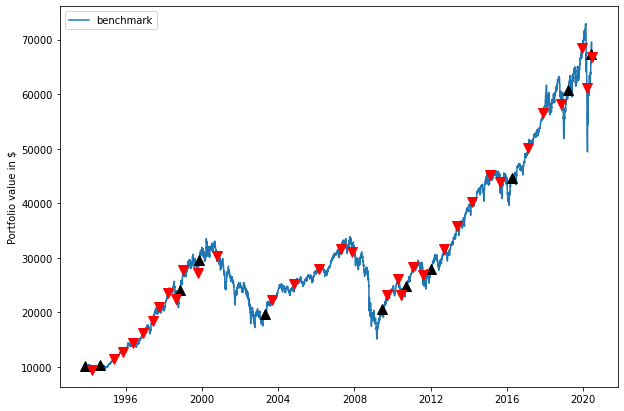

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,4.72,7.40
max_closed_out_drawdown,-10.39,-55.51
drawdown_annualized_return,-2.20,-7.50
drawdown_recovery,-0.32,-1.41
best_month,7.41,21.04
worst_month,-9.83,-31.13
sharpe_ratio,0.92,0.55
sortino_ratio,0.99,0.71
monthly_std,1.56,4.27


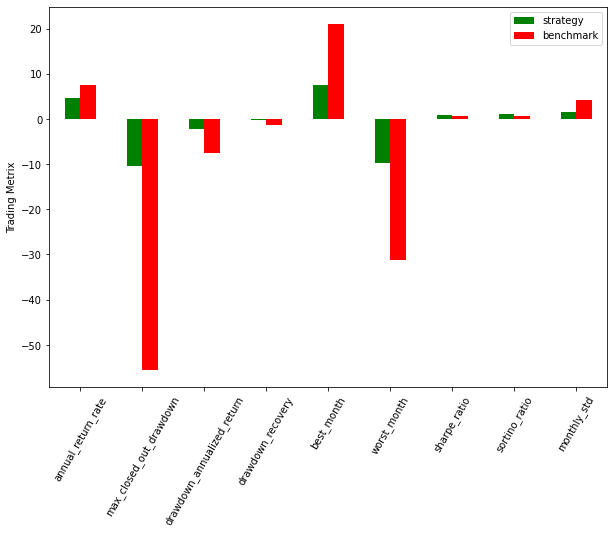

In [18]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df